In [1]:
import pandas as pd
import torch
import sys
import matplotlib.pyplot as plt


sys.path.append("../../")
from src.vae_architectures.lstm import LSTMVariationalAutoEncoder
from src.dataset import ExerciseDataset

## Load data and model

In [2]:
NUM_JOINTS = 15
SEQUENCE_LENGTH = 25
LATENT_SIZE = 256
NUM_LAYERS = 2
HIDDEN_SIZE = 256

In [3]:
dct_lstm_autoencoder = LSTMVariationalAutoEncoder(
    SEQUENCE_LENGTH, NUM_JOINTS * 3, HIDDEN_SIZE, LATENT_SIZE, NUM_LAYERS
)
dct_lstm_autoencoder.load_state_dict(
    torch.load("../../models/squat_dct_lstm.pt", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [4]:
squat_dct_df = pd.read_csv("../../data/train/dct/squat.csv")
squat_dct_dataset = ExerciseDataset(squat_dct_df, representation="dct")

squat_dct_test_df = pd.read_csv("../../data/test/dct/squat.csv")
squat_dct_dataset_test = ExerciseDataset(squat_dct_test_df, representation="dct")

## Generation of the embedded instances

In [5]:
import numpy as np

X = torch.stack([rep for rep in squat_dct_dataset.data])
y = np.array([1 if label == 0 else 0 for label in squat_dct_dataset.labels_encoded])
X_embedded = dct_lstm_autoencoder.encoder(X)[0].detach().numpy()

X_test = torch.stack([rep for rep in squat_dct_dataset_test.data])
y_test = np.array(
    [1 if label == 0 else 0 for label in squat_dct_dataset_test.labels_encoded]
)
X_test_embedded = dct_lstm_autoencoder.encoder(X_test)[0].detach().numpy()

In [6]:
from torch.utils.data import DataLoader

train_squat_dct_dl = DataLoader(
    squat_dct_dataset,
    batch_size=8,
    shuffle=True,
)

## Visualization of the latent space

/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


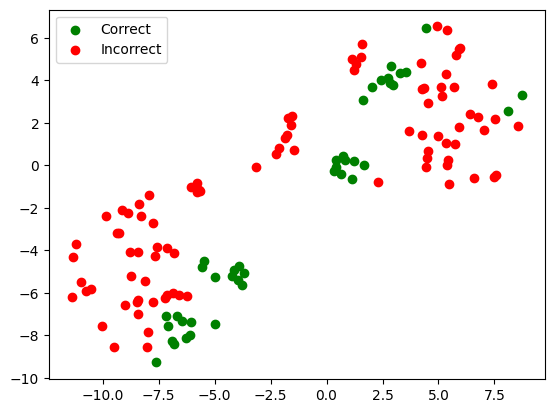

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
latent_space = tsne.fit_transform(np.concatenate([X_embedded, X_test_embedded]))
all_y = np.concatenate([y, y_test])
plt.scatter(latent_space[all_y == 1][:, 0], latent_space[all_y == 1][:, 1], c="green")
plt.scatter(latent_space[all_y == 0][:, 0], latent_space[all_y == 0][:, 1], c="red")

plt.legend(["Correct", "Incorrect"])

## Training of the classifier

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


clf = LogisticRegression().fit(X_embedded, y)
y_pred = clf.predict(X_test_embedded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.86      0.92         7

    accuracy                           0.96        25
   macro avg       0.97      0.93      0.95        25
weighted avg       0.96      0.96      0.96        25



In [9]:
import pickle

with open('../../models/clf.pkl', "rb") as f:
    clf = pickle.load(f)

## Generate CFE

In [10]:
from src.explainer import Explainer
from src.utils.data import get_random_sample

wrong_sample, sample_length, label = get_random_sample(train_squat_dct_dl, 3)
explainer = Explainer(dct_lstm_autoencoder, clf, train_squat_dct_dl, 'squat')
latent_query, cf_sample, cf_sample_decoded = explainer.generate_cf(wrong_sample)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(

/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


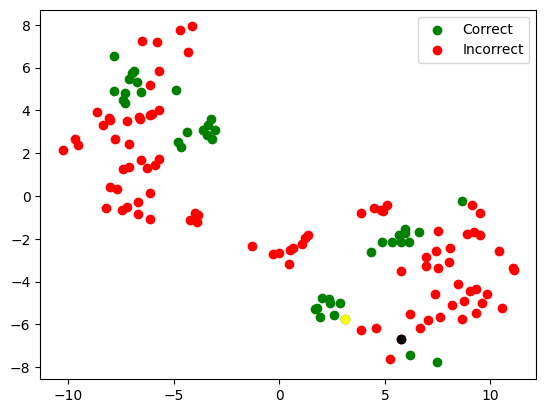

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
latent_space = tsne.fit_transform(np.concatenate([X_embedded, X_test_embedded, cf_sample, latent_query]))
all_y = np.concatenate([y, y_test, [4], [5]])
plt.scatter(latent_space[all_y == 1][:, 0], latent_space[all_y == 1][:, 1], c="green")
plt.scatter(latent_space[all_y == 0][:, 0], latent_space[all_y == 0][:, 1], c="red")
plt.scatter(latent_space[all_y == 4][:, 0], latent_space[all_y == 4][:, 1], c="yellow")
plt.scatter(latent_space[all_y == 5][:, 0], latent_space[all_y == 5][:, 1], c="black")

plt.legend(["Correct", "Incorrect"])

In [12]:
# from scipy.spatial.distance import cdist

# sample_id = 3

# query_instance = X_test_embedded[sample_id]

# closest_correct_instances = cdist(
#     np.expand_dims(query_instance, 0), X_test_embedded
# ).squeeze()
# mask = np.where(y_test == 1)[0]

# mask_argmin = closest_correct_instances[mask].argmin()
# cf_id = mask[mask_argmin]
# cf_instance = X_test_embedded[cf_id]

## Decode latent_space to DCT

In [13]:
cf_dct = dct_lstm_autoencoder.decoder(torch.tensor(cf_instance).unsqueeze(0))
original_dct = dct_lstm_autoencoder.decoder(
    torch.tensor(wrong_sample).unsqueeze(0)
)

NameError: name 'cf_instance' is not defined

## Decode DCT to pose

In [ ]:
original_dct.shape

torch.Size([1, 25, 45])

In [ ]:
from src.utils.visualization import get_3D_animation
from src.utils.data import decode_dct


cf_sample = decode_dct(
    cf_dct.detach().numpy().squeeze(), squat_dct_dataset.lengths[sample_id]
)
original_sample = decode_dct(
    original_dct.detach().numpy().squeeze(), squat_dct_dataset.lengths[sample_id]
)

## Results visualization

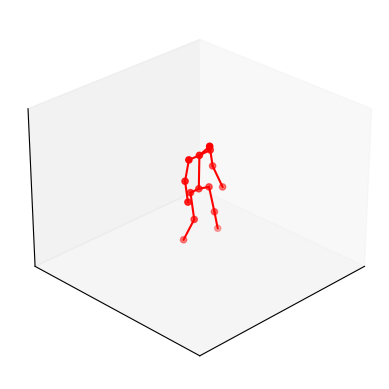

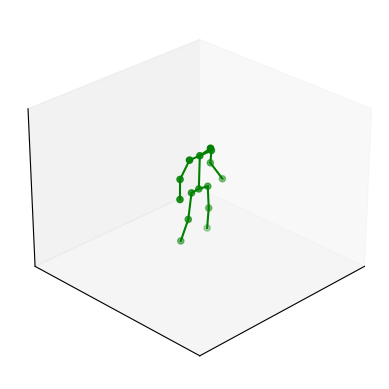

In [ ]:
original_sample_anim = get_3D_animation(original_sample, color="red")
cf_sample_anim = get_3D_animation(cf_sample, color="green");

In [ ]:
from IPython.display import HTML


html_code = f"""
<video width="400" height="300" controls>
  <source src="original_sample.mp4" type="video/mp4">
</video>
<video width="400" height="300" controls>
  <source src="cf_sample.mp4" type="video/mp4">
</video>
"""

HTML(html_code)

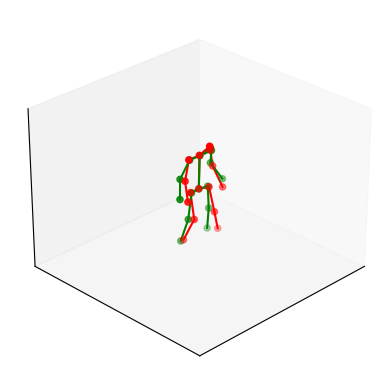

In [ ]:
from src.utils.visualization import get_3D_animation_comparison

comparison_anim = get_3D_animation_comparison(original_sample, cf_sample)

HTML(comparison_anim.to_jshtml())